**Importing libraries**

In [9]:
import networkx as nx
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
from sklearn.decomposition import TruncatedSVD
from scipy.spatial.distance import cosine

In [1]:
!pip install -U --pre matplotlib

Requirement already up-to-date: matplotlib in /usr/local/lib/python3.7/dist-packages (3.4.2)


In [2]:
#Adding TH font for visualisation
import matplotlib as mpl 
mpl.__version__  # ต้อง 3.2 ขึ้น ถึงจะเรียก addfont() ได้

'3.4.2'

In [3]:
!wget -q https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf

In [4]:
mpl.font_manager.fontManager.addfont('thsarabunnew-webfont.ttf')

In [5]:
mpl.rc('font', family='TH Sarabun New', size=12)

In [6]:
plt = mpl.pyplot

Text(0.5, 0.5, 'สวัสดีครับ ')

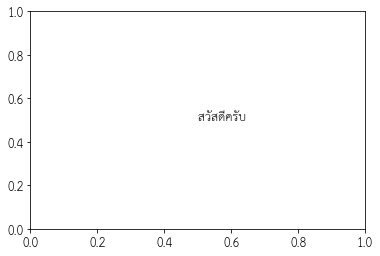

In [7]:
#Test Font
plt.text(0.5, 0.5,'สวัสดีครับ ', fontsize=12)

**Data importing and pre-processing**

In [25]:
df = pd.read_excel("Customer Survey.xlsx")
df.rename(columns = {'Unnamed: 0':'date'}, inplace=True)
df.head()

,Transaction,จักรยานเสือภูเขา,คอลลาเจน,Brownie อวกาศ,แม่โขง,Botox,กัญชา,กัญชง,เครื่องวัดความดัน,หลอดไฟเปลี่ยนสีได้,คอร์ส bikini wax,เก้าอี้นวดไฟฟ้า,ต้นไม้ประดับห้อง,หมอนข้าง,ตาชั่ง,คอร์สโบท็อกกราม,แสงโสม,กะหรี่(ปั๊บ),Lego,แฟน ที่แปลว่าพัดลม,ยาดอง,ชุดนอนไม่ได้นอน,ที่ยกน้ำหนัก (Dumbell),เครื่องดูดฝุ่นอัตโนมัติ (robot),เนื้อวากิล,หมูแดดเดียว,drone,เครื่องย่อยเศษอาหาร,เสื้อซีทรู,ไพ่ยิปซี,เนื้อย่าง,เครื่องทำลายเอกสาร,กระเป๋า,ชาบู,Surfskate,Board game,เครื่องย่อยเศษอาหาร.1,ชุดน้องหมา,Omakase,เม็ดมะม่วงหิมพานต์,ไฟอัจฉริยะ,บัตตาเลี่ยนที่ตัดผม,ไดร์เป่าผม Dyson,แผ่นเสียง,กรรไกรตัดขนจมูก,PS5,เครื่องตรวจน้ำตาลในเลือด,โรตี,กะปิดอง,น้องหมา,แพ็คเกจไทยเที่ยวไทย,เกมส์ FIFA Online,มะม่วงเบา,ห้องน้ำแมวอัตโนมัติ,กระเป๋า chanel,ข้าวขาหมูคากิคาจักออนไลน์,ถั่งเช่า,หมอนสุขภาพสำหรับคนนอนไม่หลับ,อาหารแมวคลีนเพื่อสุขภาพลดหุ่น,น้ำส้มดีโด้,Software ถูกลิขสิทธิ์,ครีมกันแดด
0,1,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย
1,2,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย
2,3,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,เคย,เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,เคย
3,4,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,เคย,ไม่เคย,เคย,เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย
4,5,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,NaN,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,เคย


In [26]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 62 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Transaction                      44 non-null     int64 
 1   จักรยานเสือภูเขา                 44 non-null     object
 2   คอลลาเจน                         44 non-null     object
 3   Brownie อวกาศ                    44 non-null     object
 4   แม่โขง                           44 non-null     object
 5   Botox                            44 non-null     object
 6   กัญชา                            44 non-null     object
 7   กัญชง                            44 non-null     object
 8   เครื่องวัดความดัน                44 non-null     object
 9   หลอดไฟเปลี่ยนสีได้               44 non-null     object
 10  คอร์ส bikini wax                 44 non-null     object
 11  เก้าอี้นวดไฟฟ้า                  44 non-null     object
 12  ต้นไม้ประดับห้อง                 44 no

In [27]:
#Consider portion of data
pd.melt(df, id_vars=['Transaction'])['value'].value_counts()

ไม่เคย    1642
เคย       1036
Name: value, dtype: int64

In [28]:
df.isnull().head(5)

,Transaction,จักรยานเสือภูเขา,คอลลาเจน,Brownie อวกาศ,แม่โขง,Botox,กัญชา,กัญชง,เครื่องวัดความดัน,หลอดไฟเปลี่ยนสีได้,คอร์ส bikini wax,เก้าอี้นวดไฟฟ้า,ต้นไม้ประดับห้อง,หมอนข้าง,ตาชั่ง,คอร์สโบท็อกกราม,แสงโสม,กะหรี่(ปั๊บ),Lego,แฟน ที่แปลว่าพัดลม,ยาดอง,ชุดนอนไม่ได้นอน,ที่ยกน้ำหนัก (Dumbell),เครื่องดูดฝุ่นอัตโนมัติ (robot),เนื้อวากิล,หมูแดดเดียว,drone,เครื่องย่อยเศษอาหาร,เสื้อซีทรู,ไพ่ยิปซี,เนื้อย่าง,เครื่องทำลายเอกสาร,กระเป๋า,ชาบู,Surfskate,Board game,เครื่องย่อยเศษอาหาร.1,ชุดน้องหมา,Omakase,เม็ดมะม่วงหิมพานต์,ไฟอัจฉริยะ,บัตตาเลี่ยนที่ตัดผม,ไดร์เป่าผม Dyson,แผ่นเสียง,กรรไกรตัดขนจมูก,PS5,เครื่องตรวจน้ำตาลในเลือด,โรตี,กะปิดอง,น้องหมา,แพ็คเกจไทยเที่ยวไทย,เกมส์ FIFA Online,มะม่วงเบา,ห้องน้ำแมวอัตโนมัติ,กระเป๋า chanel,ข้าวขาหมูคากิคาจักออนไลน์,ถั่งเช่า,หมอนสุขภาพสำหรับคนนอนไม่หลับ,อาหารแมวคลีนเพื่อสุขภาพลดหุ่น,น้ำส้มดีโด้,Software ถูกลิขสิทธิ์,ครีมกันแดด
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False


In [37]:
#Remove Null data and drop column for item-item collaborating
df1 = df.dropna().reset_index(drop=True)
df2 = df1.drop('Transaction',1)
df2.head(5)

,จักรยานเสือภูเขา,คอลลาเจน,Brownie อวกาศ,แม่โขง,Botox,กัญชา,กัญชง,เครื่องวัดความดัน,หลอดไฟเปลี่ยนสีได้,คอร์ส bikini wax,เก้าอี้นวดไฟฟ้า,ต้นไม้ประดับห้อง,หมอนข้าง,ตาชั่ง,คอร์สโบท็อกกราม,แสงโสม,กะหรี่(ปั๊บ),Lego,แฟน ที่แปลว่าพัดลม,ยาดอง,ชุดนอนไม่ได้นอน,ที่ยกน้ำหนัก (Dumbell),เครื่องดูดฝุ่นอัตโนมัติ (robot),เนื้อวากิล,หมูแดดเดียว,drone,เครื่องย่อยเศษอาหาร,เสื้อซีทรู,ไพ่ยิปซี,เนื้อย่าง,เครื่องทำลายเอกสาร,กระเป๋า,ชาบู,Surfskate,Board game,เครื่องย่อยเศษอาหาร.1,ชุดน้องหมา,Omakase,เม็ดมะม่วงหิมพานต์,ไฟอัจฉริยะ,บัตตาเลี่ยนที่ตัดผม,ไดร์เป่าผม Dyson,แผ่นเสียง,กรรไกรตัดขนจมูก,PS5,เครื่องตรวจน้ำตาลในเลือด,โรตี,กะปิดอง,น้องหมา,แพ็คเกจไทยเที่ยวไทย,เกมส์ FIFA Online,มะม่วงเบา,ห้องน้ำแมวอัตโนมัติ,กระเป๋า chanel,ข้าวขาหมูคากิคาจักออนไลน์,ถั่งเช่า,หมอนสุขภาพสำหรับคนนอนไม่หลับ,อาหารแมวคลีนเพื่อสุขภาพลดหุ่น,น้ำส้มดีโด้,Software ถูกลิขสิทธิ์,ครีมกันแดด
0,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย
1,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย
2,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,เคย,เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,เคย
3,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,เคย,ไม่เคย,เคย,เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย
4,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,เคย


In [38]:
df2.shape

(39, 61)

In [39]:
#Convert String to Value 
for i in df2.columns:
  df2[i] = df2[i].replace(['ไม่เคย'],0)
  df2[i] = df2[i].replace(['เคย'],1)

df2.head(5)

,จักรยานเสือภูเขา,คอลลาเจน,Brownie อวกาศ,แม่โขง,Botox,กัญชา,กัญชง,เครื่องวัดความดัน,หลอดไฟเปลี่ยนสีได้,คอร์ส bikini wax,เก้าอี้นวดไฟฟ้า,ต้นไม้ประดับห้อง,หมอนข้าง,ตาชั่ง,คอร์สโบท็อกกราม,แสงโสม,กะหรี่(ปั๊บ),Lego,แฟน ที่แปลว่าพัดลม,ยาดอง,ชุดนอนไม่ได้นอน,ที่ยกน้ำหนัก (Dumbell),เครื่องดูดฝุ่นอัตโนมัติ (robot),เนื้อวากิล,หมูแดดเดียว,drone,เครื่องย่อยเศษอาหาร,เสื้อซีทรู,ไพ่ยิปซี,เนื้อย่าง,เครื่องทำลายเอกสาร,กระเป๋า,ชาบู,Surfskate,Board game,เครื่องย่อยเศษอาหาร.1,ชุดน้องหมา,Omakase,เม็ดมะม่วงหิมพานต์,ไฟอัจฉริยะ,บัตตาเลี่ยนที่ตัดผม,ไดร์เป่าผม Dyson,แผ่นเสียง,กรรไกรตัดขนจมูก,PS5,เครื่องตรวจน้ำตาลในเลือด,โรตี,กะปิดอง,น้องหมา,แพ็คเกจไทยเที่ยวไทย,เกมส์ FIFA Online,มะม่วงเบา,ห้องน้ำแมวอัตโนมัติ,กระเป๋า chanel,ข้าวขาหมูคากิคาจักออนไลน์,ถั่งเช่า,หมอนสุขภาพสำหรับคนนอนไม่หลับ,อาหารแมวคลีนเพื่อสุขภาพลดหุ่น,น้ำส้มดีโด้,Software ถูกลิขสิทธิ์,ครีมกันแดด
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,1,1,1,0,0,0,0,1,0,1,1,0,1,0,0,1,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1
1,0,1,0,1,0,0,0,1,0,0,0,0,1,1,0,1,1,0,1,0,1,1,1,0,1,0,0,1,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,1,1,1,0,1,0,1,0,0,0,1,1,0,1,0,1
2,1,0,0,0,0,0,0,1,1,0,0,1,1,1,0,0,1,1,1,0,1,1,0,1,1,1,0,1,0,1,1,1,1,1,1,0,1,0,1,1,1,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,1,0,1,1,1
3,0,0,0,1,0,1,0,0,0,0,1,1,1,1,0,1,1,1,1,1,0,0,1,1,1,0,0,0,0,1,0,1,1,0,1,0,0,1,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
4,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,1,1,0,1,0,0,1,0,1,1,0,0,0,0,1,0,1,1,0,1,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,1,1,1


**Exploratory Data Analysis**

In [40]:
#Explore statistic of data
df2.describe()

,จักรยานเสือภูเขา,คอลลาเจน,Brownie อวกาศ,แม่โขง,Botox,กัญชา,กัญชง,เครื่องวัดความดัน,หลอดไฟเปลี่ยนสีได้,คอร์ส bikini wax,เก้าอี้นวดไฟฟ้า,ต้นไม้ประดับห้อง,หมอนข้าง,ตาชั่ง,คอร์สโบท็อกกราม,แสงโสม,กะหรี่(ปั๊บ),Lego,แฟน ที่แปลว่าพัดลม,ยาดอง,ชุดนอนไม่ได้นอน,ที่ยกน้ำหนัก (Dumbell),เครื่องดูดฝุ่นอัตโนมัติ (robot),เนื้อวากิล,หมูแดดเดียว,drone,เครื่องย่อยเศษอาหาร,เสื้อซีทรู,ไพ่ยิปซี,เนื้อย่าง,เครื่องทำลายเอกสาร,กระเป๋า,ชาบู,Surfskate,Board game,เครื่องย่อยเศษอาหาร.1,ชุดน้องหมา,Omakase,เม็ดมะม่วงหิมพานต์,ไฟอัจฉริยะ,บัตตาเลี่ยนที่ตัดผม,ไดร์เป่าผม Dyson,แผ่นเสียง,กรรไกรตัดขนจมูก,PS5,เครื่องตรวจน้ำตาลในเลือด,โรตี,กะปิดอง,น้องหมา,แพ็คเกจไทยเที่ยวไทย,เกมส์ FIFA Online,มะม่วงเบา,ห้องน้ำแมวอัตโนมัติ,กระเป๋า chanel,ข้าวขาหมูคากิคาจักออนไลน์,ถั่งเช่า,หมอนสุขภาพสำหรับคนนอนไม่หลับ,อาหารแมวคลีนเพื่อสุขภาพลดหุ่น,น้ำส้มดีโด้,Software ถูกลิขสิทธิ์,ครีมกันแดด
count,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.0,39.0,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.0
mean,0.358974,0.538462,0.102564,0.307692,0.179487,0.153846,0.076923,0.358974,0.256410,0.076923,0.128205,0.666667,0.871795,0.666667,0.102564,0.333333,0.948718,0.641026,0.820513,0.282051,0.179487,0.615385,0.538462,0.666667,0.794872,0.128205,0.051282,0.256410,0.256410,0.717949,0.179487,1.0,1.0,0.076923,0.666667,0.051282,0.333333,0.230769,0.897436,0.333333,0.179487,0.076923,0.205128,0.384615,0.051282,0.230769,0.974359,0.230769,0.205128,0.487179,0.128205,0.410256,0.076923,0.076923,0.102564,0.179487,0.384615,0.076923,0.717949,0.794872,1.0
std,0.485971,0.505035,0.307355,0.467572,0.388776,0.365518,0.269953,0.485971,0.442359,0.269953,0.338688,0.477567,0.338688,0.477567,0.307355,0.477567,0.223456,0.485971,0.388776,0.455881,0.388776,0.492864,0.505035,0.477567,0.409074,0.338688,0.223456,0.442359,0.442359,0.455881,0.388776,0.0,0.0,0.269953,0.477567,0.223456,0.477567,0.426833,0.307355,0.477567,0.388776,0.269953,0.409074,0.492864,0.223456,0.426833,0.160128,0.426833,0.409074,0.506370,0.338688,0.498310,0.269953,0.269953,0.307355,0.388776,0.492864,0.269953,0.455881,0.409074,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.0,1.0,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0

In [52]:
#List all products and Sorting
df3 = df2.sum().sort_values(ascending=False).to_frame()
df3 = df3.add_prefix('Amount_')
from google.colab import data_table
data_table.DataTable(df3)

,Amount_0
ครีมกันแดด,39
กระเป๋า,39
ชาบู,39
โรตี,38
กะหรี่(ปั๊บ),37
...,...
กระเป๋า chanel,3
ห้องน้ำแมวอัตโนมัติ,3
เครื่องย่อยเศษอาหาร,2
PS5,2


<AxesSubplot:>

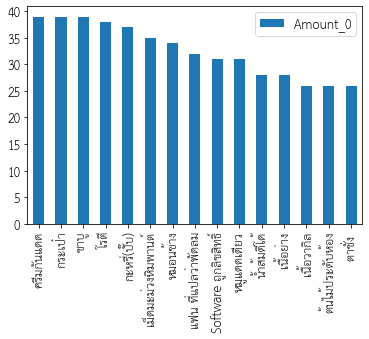

In [42]:
#Visualise top 15
df3.head(15).plot(kind = "bar")

**item-based collaborative filtering**

In [53]:
#create item-item matrix
item_item_matrix = pd.DataFrame(index=df2.columns,columns=df2.columns)
item_item_matrix.head(5)


,จักรยานเสือภูเขา,คอลลาเจน,Brownie อวกาศ,แม่โขง,Botox,กัญชา,กัญชง,เครื่องวัดความดัน,หลอดไฟเปลี่ยนสีได้,คอร์ส bikini wax,เก้าอี้นวดไฟฟ้า,ต้นไม้ประดับห้อง,หมอนข้าง,ตาชั่ง,คอร์สโบท็อกกราม,แสงโสม,กะหรี่(ปั๊บ),Lego,แฟน ที่แปลว่าพัดลม,ยาดอง,ชุดนอนไม่ได้นอน,ที่ยกน้ำหนัก (Dumbell),เครื่องดูดฝุ่นอัตโนมัติ (robot),เนื้อวากิล,หมูแดดเดียว,drone,เครื่องย่อยเศษอาหาร,เสื้อซีทรู,ไพ่ยิปซี,เนื้อย่าง,เครื่องทำลายเอกสาร,กระเป๋า,ชาบู,Surfskate,Board game,เครื่องย่อยเศษอาหาร.1,ชุดน้องหมา,Omakase,เม็ดมะม่วงหิมพานต์,ไฟอัจฉริยะ,บัตตาเลี่ยนที่ตัดผม,ไดร์เป่าผม Dyson,แผ่นเสียง,กรรไกรตัดขนจมูก,PS5,เครื่องตรวจน้ำตาลในเลือด,โรตี,กะปิดอง,น้องหมา,แพ็คเกจไทยเที่ยวไทย,เกมส์ FIFA Online,มะม่วงเบา,ห้องน้ำแมวอัตโนมัติ,กระเป๋า chanel,ข้าวขาหมูคากิคาจักออนไลน์,ถั่งเช่า,หมอนสุขภาพสำหรับคนนอนไม่หลับ,อาหารแมวคลีนเพื่อสุขภาพลดหุ่น,น้ำส้มดีโด้,Software ถูกลิขสิทธิ์,ครีมกันแดด
จักรยานเสือภูเขา,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
คอลลาเจน,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Brownie อวกาศ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
แม่โขง,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Botox,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [106]:
#@title Default title text
for i in range(0,len(item_item_matrix.columns)):
      for j in range(0,len(item_item_matrix.columns)):
            item_item_matrix.iloc[i,j] = 1 - cosine(df2.iloc[:,i],df2.iloc[:,j])
        
item_item_matrix.head(5)

,จักรยานเสือภูเขา,คอลลาเจน,Brownie อวกาศ,แม่โขง,Botox,กัญชา,กัญชง,เครื่องวัดความดัน,หลอดไฟเปลี่ยนสีได้,คอร์ส bikini wax,เก้าอี้นวดไฟฟ้า,ต้นไม้ประดับห้อง,หมอนข้าง,ตาชั่ง,คอร์สโบท็อกกราม,แสงโสม,กะหรี่(ปั๊บ),Lego,แฟน ที่แปลว่าพัดลม,ยาดอง,ชุดนอนไม่ได้นอน,ที่ยกน้ำหนัก (Dumbell),เครื่องดูดฝุ่นอัตโนมัติ (robot),เนื้อวากิล,หมูแดดเดียว,drone,เครื่องย่อยเศษอาหาร,เสื้อซีทรู,ไพ่ยิปซี,เนื้อย่าง,เครื่องทำลายเอกสาร,กระเป๋า,ชาบู,Surfskate,Board game,เครื่องย่อยเศษอาหาร.1,ชุดน้องหมา,Omakase,เม็ดมะม่วงหิมพานต์,ไฟอัจฉริยะ,บัตตาเลี่ยนที่ตัดผม,ไดร์เป่าผม Dyson,แผ่นเสียง,กรรไกรตัดขนจมูก,PS5,เครื่องตรวจน้ำตาลในเลือด,โรตี,กะปิดอง,น้องหมา,แพ็คเกจไทยเที่ยวไทย,เกมส์ FIFA Online,มะม่วงเบา,ห้องน้ำแมวอัตโนมัติ,กระเป๋า chanel,ข้าวขาหมูคากิคาจักออนไลน์,ถั่งเช่า,หมอนสุขภาพสำหรับคนนอนไม่หลับ,อาหารแมวคลีนเพื่อสุขภาพลดหุ่น,น้ำส้มดีโด้,Software ถูกลิขสิทธิ์,ครีมกันแดด
จักรยานเสือภูเขา,1,0.583212,0.267261,0.385758,0.404061,0.218218,0.154303,0.5,0.507093,0.154303,0.119523,0.524142,0.595854,0.576557,0.267261,0.370625,0.52725,0.587975,0.519701,0.241747,0.202031,0.709208,0.583212,0.524142,0.432014,0.358569,0.377964,0.338062,0.338062,0.555584,0.505076,0.599145,0.599145,0.46291,0.471728,0.377964,0.370625,0.356348,0.542105,0.667124,0.303046,0.46291,0.377964,0.552052,0.188982,0.534522,0.606977,0.445435,0.377964,0.367884,0.119523,0.467707,0.46291,0.308607,0.267261,0.101015,0.483046,0.46291,0.505076,0.62402,0.599145
คอลลาเจน,0.583212,1,0.327327,0.377964,0.57735,0.178174,0.251976,0.408248,0.345033,0.377964,0.09759,0.641941,0.673633,0.641941,0.436436,0.363137,0.717496,0.698297,0.617213,0.394771,0.412393,0.668153,0.571429,0.513553,0.587896,0.29277,0.308607,0.621059,0.483046,0.57735,0.412393,0.733799,0.733799,0.251976,0.470757,0.308607,0.544705,0.363696,0.700826,0.484182,0.329914,0.251976,0.385758,0.507093,0.154303,0.436436,0.743392,0.509175,0.46291,0.550689,0.19518,0.545545,0.377964,0.377964,0.218218,0.247436,0.563436,0.377964,0.659829,0.705476,0.733799
Brownie อวกาศ,0.267261,0.327327,1,0.433013,0.377964,0.612372,0.57735,0.133631,0.158114,0.288675,0.447214,0.392232,0.257248,0.294174,0.25,0.27735,0.328798,0.4,0.353553,0.301511,0.188982,0.408248,0.436436,0.392232,0.269408,0.447214,0.353553,0.158114,0.316228,0.283473,0.188982,0.320256,0.320256,0.288675,0.294174,0.353553,0.138675,0.333333,0.338062,0.416025,0.377964,0.288675,0.53033,0.258199,0.353553,0.333333,0.324443,0.333333,0.176777,0.229416,0.447214,0.25,0.57735,0.866025,0.5,0.188982,0.387298,0.57735,0.283473,0.359211,0.320256
แม่โขง,0.385758,0.377964,0.433013,1,0.218218,0.471405,0.333333,0.385758,0.273861,0.166667,0.516398,0.566139,0.495074,0.396297,0.144338,0.880705,0.569495,0.404145,0.51031,0.348155,0.327327,0.53033,0.503953,0.566139,0.570323,0.387298,0.204124,0.273861,0.456435,0.49099,0.218218,0.5547,0.5547,0.166667,0.452911,0.204124,0.0800641,0.481125,0.58554,0.240192,0.327327,0.333333,0.408248,0.596285,0.204124,0.19245,0.561951,0.3849,0,0.331133,0.387298,0.433013,0.5,0.333333,0.144338,0.218218,0.521749,0.333333,0.436436,0.362933,0.5547
Botox,0.404061,0.57735,0.377964,0.218218,1,0.154303,0.218218,0.303046,0.358569,0.218218,0.169031,0.2965,0.388922,0.2965,0.755929,0.209657,0.372822,0.302372,0.467707,0.341882,0.428571,0.540062,0.329914,0.370625,0.271538,0.169031,0.267261,0.478091,0.358569,0.357143,0.285714,0.423659,0.423659,0.218218,0.14825,0.267261,0.314485,0.251976,0.383326,0.314485,0.285714,0.218218,0.267261,0.39036,0.267261,0.503953,0.429198,0.377964,0.267261,0.346844,0.169031,0.283473,0.218218,0.436436,0.377964,0.142857,0.39036,0.218218,0.285714,0.475191,0.423659


In [57]:
#Plot Network Graph
links =  item_item_matrix.stack().reset_index()
links.columns = ['item1', 'item2','cosine_value']
links

,item1,item2,cosine_value
0,จักรยานเสือภูเขา,จักรยานเสือภูเขา,1
1,จักรยานเสือภูเขา,คอลลาเจน,0.583212
2,จักรยานเสือภูเขา,Brownie อวกาศ,0.267261
3,จักรยานเสือภูเขา,แม่โขง,0.385758
4,จักรยานเสือภูเขา,Botox,0.404061
...,...,...,...
3716,ครีมกันแดด,หมอนสุขภาพสำหรับคนนอนไม่หลับ,0.620174
3717,ครีมกันแดด,อาหารแมวคลีนเพื่อสุขภาพลดหุ่น,0.27735
3718,ครีมกันแดด,น้ำส้มดีโด้,0.847319
3719,ครีมกันแดด,Software ถูกลิขสิทธิ์,0.891556


In [112]:
#Filter cosine to address weak link
links_filter = links.loc[ (links['cosine_value'] > 0.50) & (links['item1'] != links['item2']) ]
links_filter.sort_values(by='cosine_value',ascending=True)

,item1,item2,cosine_value
2435,ไฟอัจฉริยะ,หมอนสุขภาพสำหรับคนนอนไม่หลับ,0.50128
3452,หมอนสุขภาพสำหรับคนนอนไม่หลับ,ชุดน้องหมา,0.50128
3455,หมอนสุขภาพสำหรับคนนอนไม่หลับ,ไฟอัจฉริยะ,0.50128
2252,ชุดน้องหมา,หมอนสุขภาพสำหรับคนนอนไม่หลับ,0.50128
2276,Omakase,ยาดอง,0.502519
...,...,...,...
1983,ชาบู,กระเป๋า,1
2161,เครื่องย่อยเศษอาหาร.1,เครื่องย่อยเศษอาหาร,1
1923,กระเป๋า,ชาบู,1
3692,ครีมกันแดด,ชาบู,1


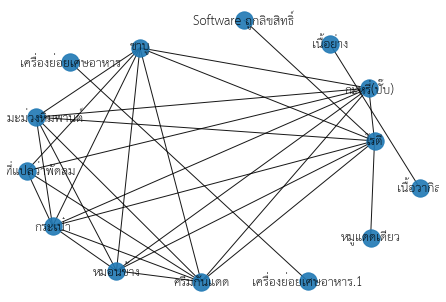

<Figure size 1440x1440 with 0 Axes>

In [103]:
# Build Network graph
import networkx as nx

G=nx.from_pandas_edgelist(links_filter, 'item1', 'item2','cosine_value')
labels_params = {'font_family': 'TH Sarabun New', 'alpha':.9, 'font_size':12}
pos = nx.spring_layout(G, k=5, weight='cosine_value', iterations=80, seed=90, scale=2.5)
#pos = nx.spring_layout(G)
nx.draw(G, pos,**labels_params)
nx.draw_networkx_labels(G, pos,**labels_params)
edge_labels = nx.get_edge_attributes(G,'cosine_value')
plt.figure(figsize=(20,20))

plt.show()



## **Interpretation**

จากการ Run Model Item-Item Collaborative Filtering ด้วยวิธีการหาค่า Cosine similarity พบความสัมพันธ์ในหลายๆรูปแบบทั้งของที่ไปในทางทิศเดียวกัน เช่นเป็นอาหารเหมือนกัน หรือของที่่คนละทิศละทาง ไม่น่าจะสัมพันธ์กันได้